# ConvNet (CIFAR-10)

here’s a cleaner statement that keeps the minimization objective abstract but unpacks the *inside* of $f_\theta$ layer‑by‑layer and pins down what “convolution” and “pool” actually do.

---

## 0. objective (unchanged)

$$
\theta^{\star}
=\arg\min_{\theta}\;
\frac1N\sum_{i=1}^{N}\;
\ell\bigl(f_\theta(x_i),\,y_i\bigr)\;+\;\lambda\lVert\theta\rVert_2^{2}.
$$

everything interesting hides in $f_\theta$.

---

## 1. canonical cnn recursion

set $h_0=x$. for each **conv block** $1\le\ell\le L_c$:

$$
\begin{aligned}
z_\ell &= \text{Conv}\bigl(h_{\ell-1};\,W_\ell\bigr)+b_\ell,\\
a_\ell &= \sigma\!\bigl(z_\ell\bigr),\\
h_\ell &= 
\begin{cases}
\text{Pool}\bigl(a_\ell\bigr) & \text{if block }\ell\text{ has pooling},\\
a_\ell & \text{otherwise}.
\end{cases}
\end{aligned}
$$

flatten $h_{L_c}$ to a vector and push it through fully connected layers the same way:

$$
h_{\ell+1}= \sigma\!\bigl(W_{\ell+1}h_\ell+b_{\ell+1}\bigr),
\qquad L_c\le\ell<L_c+L_f.
$$

after the last affine layer you may drop the final $\sigma$ and apply soft‑max externally—whatever your loss expects.

all parameters $\theta=\{W_\ell,b_\ell\}_{\ell=1}^{L_c+L_f}$.

---

## 2. convolution spelled out

input tensor
$h_{\ell-1}\in\mathbb R^{H\times W\times C_\text{in}}$.

kernel tensor
$W_\ell\in\mathbb R^{k_h\times k_w\times C_\text{in}\times C_\text{out}}$.

for zero‑padding $p$ and stride $s$,

$$
\boxed{
\;z_\ell(i,j,c)=
\!\!\sum_{u=0}^{k_h-1}\sum_{v=0}^{k_w-1}\sum_{d=0}^{C_\text{in}-1}
W_\ell(u,v,d,c)\;
h_{\ell-1}(i\,s+u-p,\,j\,s+v-p,\,d)
\;} 
$$

(the operation used in deep‑learning libraries is technically cross‑correlation; if you flip the kernel spatially you get the mathematician’s convolution) ([arXiv][1])

output spatial size:

$H'=\bigl\lfloor\frac{H+2p-k_h}{s}\bigr\rfloor+1,\;\;
W'=\bigl\lfloor\frac{W+2p-k_w}{s}\bigr\rfloor+1.$

---

## 3. pooling variants

for a channel‑wise window of size $p_h\times p_w$ and stride $s_p$:

* **max‑pool**

  $$
  \text{Pool}_\text{max}(a)(i,j,c)=
  \max_{\substack{0\le u<p_h\\0\le v<p_w}}
  a\bigl(i\,s_p+u,\;j\,s_p+v,\;c\bigr)
  $$

* **average‑pool**

  replace the max with a mean.

window shape and stride rule the down‑sampling; nothing exotic is happening.

---

## 4. why this matters

* the sparse, weight‑sharing structure of the Conv formula bakes **translation equivariance** and keeps parameter count $O(k_hk_wC_\text{in}C_\text{out})$ instead of $O(HWC_\text{in}C_\text{out})$.
* pooling trades spatial resolution for a larger effective receptive field and a bit of invariance.
* the recursion above is the skeleton you back‑prop through; everything else (batch‑norm, residual skip, dilations, etc.) just adds detours inside the $g_\ell$.

In [59]:
# Imports
import jax
import jax.numpy as jnp

# From https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
    return d

In [60]:
data = unpickle('data/cifar-10-batches-py/data_batch_1')
data.keys()


dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [61]:
# let's get a sense for what everything is.
print(list(type(data[key]) for key in data.keys()))

[<class 'bytes'>, <class 'list'>, <class 'numpy.ndarray'>, <class 'list'>]


In [62]:
data[b'batch_label'] # can be ignored

b'training batch 1 of 5'

In [63]:
len(data[b'labels'])

10000

In [64]:
data[b'data'].shape

(10000, 3072)

In [65]:
jnp.sqrt(3072/3) # 32x32, 3 channels

Array(32., dtype=float32, weak_type=True)

In [66]:
data[b'filenames'][:10] # maybe we can cheat with some NLP

[b'leptodactylus_pentadactylus_s_000004.png',
 b'camion_s_000148.png',
 b'tipper_truck_s_001250.png',
 b'american_elk_s_001521.png',
 b'station_wagon_s_000293.png',
 b'coupe_s_001735.png',
 b'cassowary_s_001300.png',
 b'cow_pony_s_001168.png',
 b'sea_boat_s_001584.png',
 b'tabby_s_001355.png']

In [67]:
list(zip(data[b'labels'][:10], data[b'filenames'][:10])) # looks like the classes are 0-9, in the order described in the info document.

[(6, b'leptodactylus_pentadactylus_s_000004.png'),
 (9, b'camion_s_000148.png'),
 (9, b'tipper_truck_s_001250.png'),
 (4, b'american_elk_s_001521.png'),
 (1, b'station_wagon_s_000293.png'),
 (1, b'coupe_s_001735.png'),
 (2, b'cassowary_s_001300.png'),
 (7, b'cow_pony_s_001168.png'),
 (8, b'sea_boat_s_001584.png'),
 (3, b'tabby_s_001355.png')]

In [80]:
def process_single_batch(batch):
    X, y = jnp.array(batch[b'data']), jnp.array(batch[b'labels'])
    X = jnp.reshape(X, (-1, 3, 32, 32))
    X = jnp.transpose(X, [0, 2, 3, 1])
    return X, y

def load_and_combine_full_training_set():
    Xs, ys = [], []
    for i in range(1, 6):
        X, y = process_single_batch(unpickle(f'data/cifar-10-batches-py/data_batch_{i}'))
        Xs.append(X)
        ys.append(y)
    X = jnp.concatenate(Xs)
    y = jnp.concatenate(ys)
    return X, y

def augment_data(X_train):
    # horizontal_flip
    X_train = jnp.concatenate([X_train, X_train[:, :, :, ::-1]])
    return X_train

X_train, y_train = load_and_combine_full_training_set()
X_train = augment_data(X_train)
X_train.shape, y_train.shape



((100000, 32, 32, 3), (50000,))

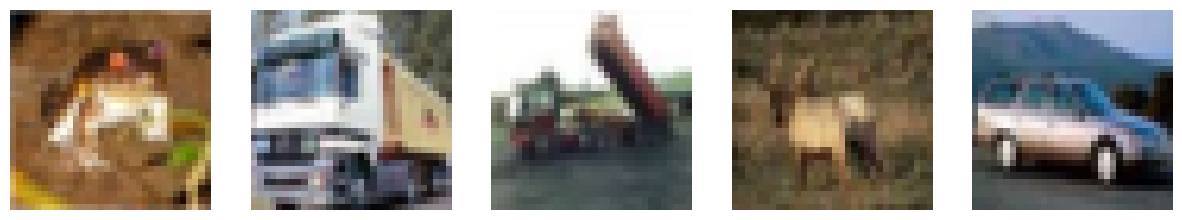

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# assuming X_train is jax.numpy array of shape (N, 32, 32, 3)
# convert first 5 images to numpy for plotting
images = np.array(X_train[:5])

# plot
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis('off')
plt.show()


In [82]:
def get_epoch_batches(X, y, key, batch_size):
    num = (X.shape[0] // batch_size) * batch_size
    perm = jax.random.permutation(key, X.shape[0])[:num]
    X, y = X[perm], y[perm]
    X = X.reshape(-1, batch_size, *X.shape[1:])
    y = y.reshape(-1, batch_size, *y.shape[1:])
    return X, y

def expand_batch(X):
    X /= 255
    return X

bX, by = get_epoch_batches(X_train, y_train, jax.random.key(0), 128)
bX.shape, by.shape

((781, 128, 32, 32, 3), (781, 128))

In [96]:
# Model construction

# Recommended model by chatgpt:
# Conv2D(32, kernel_size=3, activation='relu')
# Conv2D(64, kernel_size=3, activation='relu')
# MaxPool2D(pool_size=2)
# Flatten()
# Dense(128, activation='relu')
# Dense(10, activation='softmax')

# Aim to get >70%.
from jax import lax

def init_conv2d(key, size, in_channels, out_channels):
    k1, k2 = jax.random.split(key)
    std = jnp.sqrt(2 / (size*size))
    W = std*jax.random.normal(k1, (size, size, in_channels, out_channels)) # HWIO
    b = jnp.zeros((out_channels,)) # one per out_channel
    return W, b

def init_dense(key, in_size, out_size):
    k1, k2 = jax.random.split(key)
    std = jnp.sqrt(2 / in_size)
    W = std * jax.random.normal(k1, (in_size, out_size))
    b = jnp.zeros((out_size,))
    return W, b

def init_params(key):
    k1, k2, k3, k4, k5, k6, k7, k8, k9 = jax.random.split(key, 9)
    c1 = init_conv2d(k1, 3, 3, 32) # 30x30
    c2 = init_conv2d(k2, 3, 32, 64) # 28x28
    # maxpool
    c3 = init_conv2d(k3, 3, 64, 128) # 12x12
    c4 = init_conv2d(k4, 3, 128, 256) # 10x10
    # maxpool
    c5 = init_conv2d(k5, 3, 256, 512) # 3x3
    c6 = init_conv2d(k6, 3, 512, 1024) # 1x1

    d1 = init_dense(k7, 1024, 512)
    d2 = init_dense(k8, 512, 128)
    d3 = init_dense(k9, 128, 10)

    # d1 = jnp.random.normal(k3, 
    return [c1, c2, c3, c4, c5, c6, d1, d2, d3]

def dropout(x, key, rate=0.001):
    keep_prob = 1.0 - rate
    mask = jax.random.bernoulli(key, p=keep_prob, shape=x.shape)
    return jnp.where(mask, x / keep_prob, 0.0)

from functools import partial

@partial(jax.jit, static_argnames=['use_dropout'])
def fwd(params, X, key=None, use_dropout=False):
    if use_dropout:
        keys = jax.random.split(key, 4)

    X = expand_batch(X)

    c1, c2, c3, c4, c5, c6, d1, d2, d3 = params

    X = lax.conv(jnp.transpose(X, [0,3,1,2]),
                 jnp.transpose(c1[0], [3,2,0,1]),
                 (1, 1), 'SAME') + c1[1][:, None, None]
    X = jax.nn.relu(X)
    # if use_dropout:
    #     X = dropout(X, keys[0])
    X = lax.reduce_window(X, -jnp.inf, lax.max, (1, 1, 2, 2), (1, 1, 2, 2))

    X = lax.conv(X, jnp.transpose(c2[0], [3,2,0,1]),
                 (1, 1), 'SAME') + c2[1][:, None, None]
    X = jax.nn.relu(X)
    # if use_dropout:
    #     X = dropout(X, keys[1])
    X = lax.reduce_window(X, -jnp.inf, lax.max, (1, 1, 2, 2), (1, 1, 2, 2))


    X = lax.conv(X, jnp.transpose(c3[0], [3,2,0,1]), (1, 1), 'SAME') + c3[1][:, None, None]
    X = jax.nn.relu(X)
    X = lax.reduce_window(X, -jnp.inf, lax.max, (1, 1, 2, 2), (1, 1, 2, 2))
    X = lax.conv(X, jnp.transpose(c4[0], [3,2,0,1]), (1, 1), 'SAME') + c4[1][:, None, None]
    X = jax.nn.relu(X)
    X = lax.reduce_window(X, -jnp.inf, lax.max, (1, 1, 2, 2), (1, 1, 2, 2))

    X = lax.conv(X, jnp.transpose(c5[0], [3,2,0,1]), (1, 1), 'SAME') + c5[1][:, None, None]
    X = jax.nn.relu(X)
    X = lax.reduce_window(X, -jnp.inf, lax.max, (1, 1, 2, 2), (1, 1, 2, 2))

    X = lax.conv(X, jnp.transpose(c6[0], [3,2,0,1]), (1, 1), 'SAME') + c6[1][:, None, None]
    X = jax.nn.relu(X)
    
    X = X.reshape(X.shape[0], -1)

    X = jax.nn.relu(X @ d1[0] + d1[1])
    if use_dropout:
        X = dropout(X, keys[2])
    X = jax.nn.relu(X @ d2[0] + d2[1])
    if use_dropout:
        X = dropout(X, keys[3])

    return X @ d3[0] + d3[1]





In [97]:

def loss(params, X, y, key=None, use_dropout=False):
    logits = fwd(params, X, key, use_dropout)
    # log_probs = jax.nn.log_softmax(logits)
    return -jnp.mean(jnp.sum(jax.nn.one_hot(y, 10)*jax.nn.log_softmax(logits), axis=1))

    
grad_loss = jax.jit(jax.grad(loss), static_argnames="use_dropout")

In [98]:
# fwd(init_params(jax.random.key(0)), expand_batch(get_epoch_batches(X_train, y_train, jax.random.key(0), 128)[0][0]))

bX, by = get_epoch_batches(X_train, y_train, jax.random.key(0), 128)
loss(init_params(jax.random.key(0)), bX[0], by[0])

Array(205773.48, dtype=float32)

In [99]:
def init_sgd(params):
    velocity = jax.tree_util.tree_map(jnp.zeros_like, params)
    return params, velocity

@jax.jit
def sgd_update(params, velocity, grads, lr=5e-5, momentum=0.9):
    velocity = jax.tree.map(lambda v, g: momentum * v - lr * g, velocity, grads)
    params = jax.tree.map(lambda p, v: p + v, params, velocity)
    return params, velocity

@jax.jit
def train_sgd(X, y, key, init_params, batch_size=64, num_epochs=100):
    keys = jax.random.split(key, num_epochs)
    params, velocity = init_sgd(init_params)

    def epoch_step(i, opt_state):
        params, velocity = opt_state
        k1, k2 = jax.random.split(keys[i])
        bX, by = get_epoch_batches(X, y, k1, batch_size)
        batch_keys = jax.random.split(k2, len(by))

        def batch_step(opt_state, batch):
            p, v = opt_state
            Xb, yb, batch_key = batch
            _, stats = compute_minibatch_loss(p, batch)
            grads = grad_loss(p, Xb, yb, batch_key, True)
            p, v = sgd_update(p, v, grads)
            return (p, v), stats

        (params_, velocity_), (accuracies, losses) = jax.lax.scan(batch_step, (params, velocity), (bX, by, batch_keys))

        epoch_loss = jnp.mean(losses)
        epoch_acc = jnp.mean(accuracies)
        jax.debug.print("epoch {i}, loss: {l}, accuracy: {a}", i=i, l=epoch_loss, a=epoch_acc)
        return params_, velocity_

    params, velocity = jax.lax.fori_loop(0, num_epochs, epoch_step, (params, velocity))
    return params

In [100]:
params = train_adam(X_train, y_train, jax.random.key(0), init_params(jax.random.key(0)))

epoch 0, loss: 14714.3642578125, accuracy: 0.4516945481300354
epoch 1, loss: 2769.8291015625, accuracy: 0.4894866347312927
epoch 2, loss: 6.560249328613281, accuracy: 0.5480954051017761
epoch 3, loss: 2.8956284523010254, accuracy: 0.5496358871459961
epoch 4, loss: 2.2454094886779785, accuracy: 0.5499460101127625
epoch 5, loss: 2.0828137397766113, accuracy: 0.5499659776687622
epoch 6, loss: 2.072011947631836, accuracy: 0.5500159859657288
epoch 7, loss: 2.0401575565338135, accuracy: 0.5499259829521179
epoch 8, loss: 1.9124237298965454, accuracy: 0.549996018409729
epoch 9, loss: 1.970601201057434, accuracy: 0.549996018409729
epoch 10, loss: 1.8976372480392456, accuracy: 0.5499559640884399
epoch 11, loss: 1.8305498361587524, accuracy: 0.549996018409729
epoch 12, loss: 1.7708632946014404, accuracy: 0.5499860048294067
epoch 13, loss: 1.7478082180023193, accuracy: 0.5499559640884399
epoch 14, loss: 1.7286807298660278, accuracy: 0.549996018409729
epoch 15, loss: 1.7135047912597656, accuracy: 0

In [ ]:
X_test, y_test = process_single_batch(unpickle(f'data/cifar-10-batches-py/test_batch'))
X_test.shape, y_test.shape

In [ ]:
def compute_minibatch_loss(params, batch):
    Xb, yb = batch
    # print(jnp.argmax(fwd(params, Xb), axis=1).shape)
    minibatch_accuracy = jnp.mean(yb == jnp.argmax(fwd(params, Xb), axis=1))
    print(yb)
    print(jnp.argmax(fwd(params, Xb), axis=1))
    return params, (minibatch_accuracy, loss(params, Xb, yb))

_, (minibatch_accuracy, minibatch_losses) = jax.lax.scan(compute_minibatch_loss, params, get_epoch_batches(X_test, y_test, jax.random.key(0), batch_size = 128))
test_loss = jnp.mean(minibatch_losses)
test_accuracy = jnp.mean(minibatch_accuracy)
test_loss, test_accuracy

In [ ]:
def compute_minibatch_loss(params, batch):
    Xb, yb = batch
    # print(jnp.argmax(fwd(params, Xb), axis=1).shape)
    minibatch_accuracy = jnp.mean(yb == jnp.argmax(fwd(params, Xb), axis=1))
    print(yb)
    print(jnp.argmax(fwd(params, Xb), axis=1))
    print(jnp.bincount(jnp.argmax(fwd(params, Xb), axis=1)))

    return None, (minibatch_accuracy, loss(params, Xb, yb))

bX, by =  get_epoch_batches(X_test, y_test, jax.random.key(0), batch_size=128)
compute_minibatch_loss(params, (bX[0], by[0]))
print(fwd(params, bX[0]))


In [ ]:
def compute_minibatch_loss(params, batch):
    Xb, yb = batch
    logits = fwd(params, Xb)
    preds = jnp.argmax(logits, axis=1)
    acc = jnp.mean(preds == yb)
    l = loss(params, Xb, yb)
    return params, (acc, l)  # carry is just params (unused)

_, (accuracies, losses) = jax.lax.scan(
    lambda carry, batch: compute_minibatch_loss(carry, batch),
    params,
    get_epoch_batches(X_test, y_test, jax.random.key(0), batch_size=128)
)

test_loss = jnp.mean(losses)
test_acc = jnp.mean(accuracies)


In [ ]:
test_loss, test_acc